In [1]:
# Torch
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim 
from torchsummary import summary


# Train + Data 
import sys 
sys.path.append('../Layers')
from Conv1d_NN import *
from Conv2d_NN import *
from Conv1d_NN_spatial import * 
from Conv2d_NN_spatial import * 
from ConvNN_CNN_Branching import *

sys.path.append('../Data')
from BSD68 import * 
from CIFAR10 import *


sys.path.append('../Models')
from denoising_models import * 

sys.path.append('../Train')
from train2d import * 



import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

import torch 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets


/Users/mingikang/miniforge3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_images(directory):
    images = []
    
    for filename in os.listdir(directory):
        try: 
            img = Image.open(os.path.join(directory, filename)).convert('L')  # Convert to grayscale
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            img_array = torch.from_numpy(img_array).float()
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
        
    return images

def create_image_set(images, target_count, target_size=100):
    
    image_set = []
    
    for i in range(target_count):
        img = random.choice(images)
        img = img.unsqueeze(0)  # Add batch dimension

        transform_list = [transforms.RandomCrop(target_size)]
        
        if random.random() > 0.3:  # 30% chance of flipping
            transform_list.append(transforms.RandomHorizontalFlip(p=1.0))  # p=1.0 means always flip
        
        if random.random() > 0.3:  # 30% chance of flipping
            transform_list.append(transforms.RandomVerticalFlip(p=1.0))  # p=1.0 means always flip
            
        rotational_angles = [90, 180, 270]
        if random.random() > 0.3: # 30% chance of rotating
            rotation_angle = random.choice(rotational_angles)
            transform_list.append(transforms.RandomRotation(degrees=(rotation_angle, rotation_angle)))

        transform = transforms.Compose(transform_list)
        transformed_img = transform(img)
        image_set.append(transformed_img.squeeze(0))  # Remove batch dimension
        
    print(f"Images of count: {target_count} has been created with size: {target_size}.")
    return image_set
    
def visual(data, n=1): 
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img = data[i]
        
        # Display original image
        plt.subplot(2, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    

In [3]:
images = load_images("/Users/mingikang/Developer/Convolutional-Nearest-Neighbor/Data/BSD68_data")

train_images = create_image_set(images, 5000, target_size=100)
test_images = create_image_set(images, 500, target_size=100)




Images of count: 5000 has been created with size: 100.
Images of count: 500 has been created with size: 100.


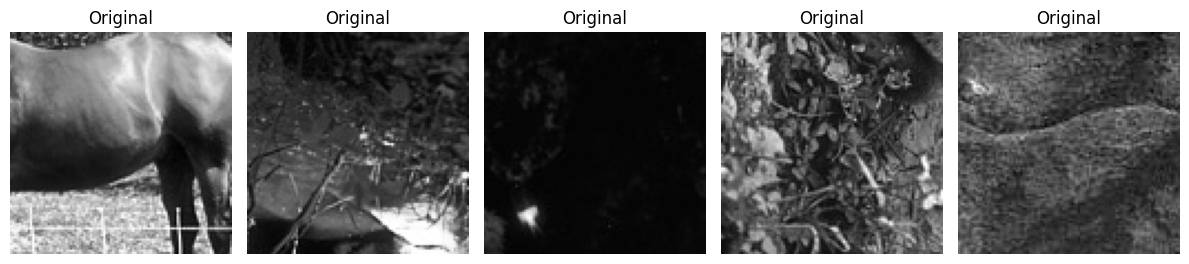

In [4]:
visual(train_images, 5)

### Example Transformations in Torch

torch.Size([321, 481])


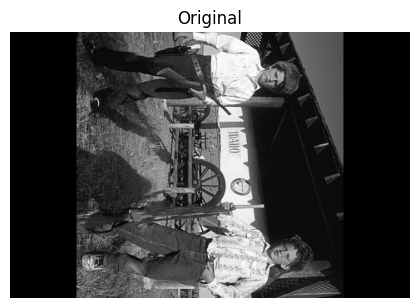

In [23]:
# RandomAffine - Rotation

degrees =  90 # Rotation between -10 and 10 degrees
# translate = (0.1, 0.1)  # Translate up to 10% of width and height
# scale = (0.9, 1.1)  # Scale between 90% and 110%
# shear = (-5, 5)  #

transformed_images = []
for img in images:
    # transform = transforms.RandomAffine(degrees=degrees, translate=translate, scale=scale, shear=shear)
    transform = transforms.RandomAffine(degrees=(degrees, degrees))
    transformed_images.append(transform(img.unsqueeze(0)).squeeze(0))

visual(transformed_images, n=1)

torch.Size([321, 481])


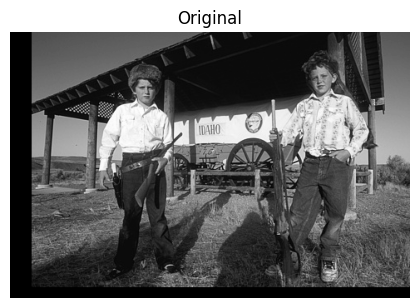

In [24]:
# RandomAffine - Translation

translate = (0.3, 0.3)  # Translate up to 10% of width and height

transformed_images = []
for img in images:
    transform = transforms.RandomAffine(0, translate=translate)
    transformed_images.append(transform(img.unsqueeze(0)).squeeze(0))
    
visual(transformed_images, n=1)

torch.Size([321, 481])


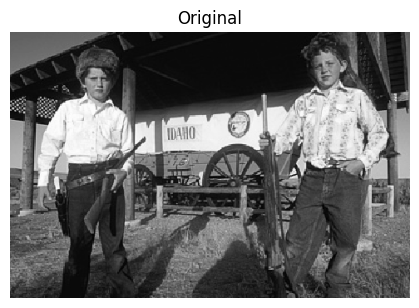

In [25]:
# RandomAffine - Scale

scale = (1.3, 1.3)  # Scale between 90% and 110%

transformed_images = []
for img in images:
    transform = transforms.RandomAffine(0, scale=scale)
    transformed_images.append(transform(img.unsqueeze(0)).squeeze(0))

visual(transformed_images, n=1)

torch.Size([321, 481])


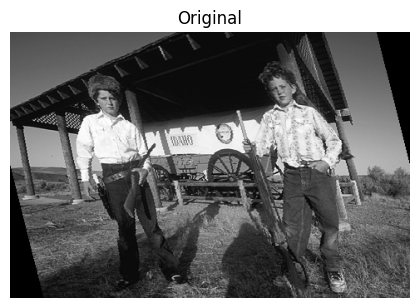

In [26]:
# RandomAffine - Sheer

shear = (-20, 20)

transformed_images = []
for img in images:
    transform = transforms.RandomAffine(0, shear=shear)
    transformed_images.append(transform(img.unsqueeze(0)).squeeze(0))

visual(transformed_images, n=1)

torch.Size([321, 481])


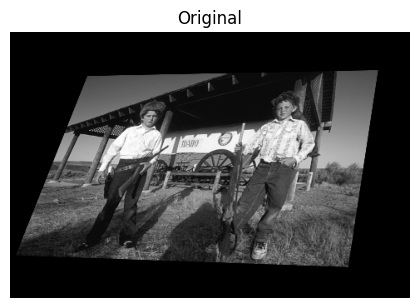

In [27]:
# RandomPerspective

transformed_images = []
for img in images:
    transform = transforms.RandomPerspective()
    transformed_images.append(transform(img.unsqueeze(0)).squeeze(0))
 
visual(transformed_images, n=1)

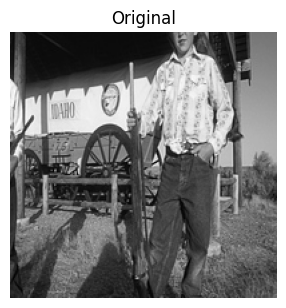

torch.Size([200, 200])


In [78]:
# RandomCrop

transformed_images = []
for img in images:
    transform = transforms.RandomCrop(200)
    transformed_images.append(transform(img.unsqueeze(0)).squeeze(0))
 
visual(transformed_images, n=1)
print(transformed_images[0].shape)

torch.Size([321, 481])


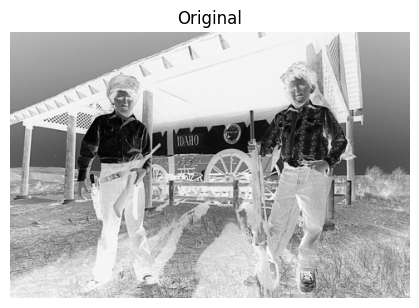

torch.Size([321, 481])


In [28]:
# RandomInvert

transformed_images = []
for img in images:
    transform = transforms.RandomInvert(0.2)
    transformed_images.append(transform(img.unsqueeze(0)).squeeze(0))
 
visual(transformed_images, n=1)
print(transformed_images[0].shape)